Hyperparameter Tuning:

Optimizer                      
Learning Rates  
Batch Sizes  
Epochs  
Number of neurons   
Number of layers  

Loss Func: MSE (MAPE not recommended)

Performance: R square, RMSE, MAPE

LSTM with multistep prediction (No EMA_40)

Next step:  
Add Variance/Volatility  
Test using different prediction step (13,26,52)  
Consider using only certain timestep for prediction (eg. 5 years, 3 years, 1 years)  
Hyperparameter Tune
Maybe can add long-term and short-term trend model

In [1]:
# !pip install stock-indicators

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, TimeDistributed, Masking, Lambda
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

mixed_precision.set_global_policy(mixed_precision.Policy('mixed_float16'))

from sklearn.model_selection import TimeSeriesSplit, train_test_split

In [2]:
# Weekly data
data = pd.read_excel('KLCI Data.xlsx')

display(data)
data.corr()

,Date,Close,Vol,S&P_close,Regime
0,2004-01-12,817.270020,370931800,1139.829956,1
1,2004-01-19,824.659973,153048200,1141.550049,1
2,2004-01-26,818.940002,398119800,1131.130005,1
3,2004-02-02,815.419983,289028200,1142.760010,1
4,2004-02-09,825.909973,419423200,1145.810059,1
...,...,...,...,...,...
1087,2024-11-11,1592.439941,917706300,5870.620117,1
1088,2024-11-18,1589.780029,929898200,5969.339844,1
1089,2024-11-25,1594.290039,1509717600,6032.379883,1
1090,2024-12-02,1613.250000,1086253600,6090.270020,1


,Date,Close,Vol,S&P_close,Regime
Date,1.000000,0.668006,0.137367,0.904861,-0.021695
Close,0.668006,1.000000,0.021786,0.417594,-0.050135
Vol,0.137367,0.021786,1.000000,0.158326,-0.348529
S&P_close,0.904861,0.417594,0.158326,1.000000,0.028998
Regime,-0.021695,-0.050135,-0.348529,0.028998,1.000000


In [3]:
# Dataset Preprocessing
price_ori = (data['Close'].values.reshape(-1, 1))
V = pd.DataFrame(price_ori).rolling(window=13, min_periods=2).var().shift(1)
V = V.fillna(0)

feat_ori = data.loc[:,['Vol', 'Regime', 'S&P_close']]

feat_ori = pd.concat([feat_ori, V], axis=1)

feat_ori = feat_ori[['Vol', 'Regime', 0, 'S&P_close']].values.reshape(-1,4)
# Data Normalization
pscaler = StandardScaler()
price = pscaler.fit_transform(price_ori)

fscaler = StandardScaler()
feat = fscaler.fit_transform(feat_ori)

# print(fscaled_data[:,3])
print(price.shape, feat.shape)


# Create dataset from t=0 to t=t
def create_data(price, feat, initial=100, interval=10, predict_step=10, max=2000):
    n = (len(price)-initial-predict_step) // interval
    x = []
    f = []
    y = []

    # To monitor datasize timeframe
    # timeframe = []
    for i in range(n):
        x.append(price[:(initial+i*interval)])
        f.append(feat[:(initial+i*interval)])
        y.append(price[(initial+i*interval):(initial+i*interval+predict_step), 0:1])
        
        # timeframe.append(initial+i*interval)

    # print(timeframe)

    # Padding
    x = pad_sequences(x, maxlen=max, padding='pre', value=-10000, dtype='float32')
    f = pad_sequences(f, maxlen=max, padding='pre', value=-10000, dtype='float32')
    
    return np.array(x), np.array(f), np.array(y)


x, f, y  = create_data(price, feat, 100, 10, 53, 600)
print(x.shape, f.shape, y.shape)

(1092, 1) (1092, 4)
(93, 600, 1) (93, 600, 4) (93, 53, 1)


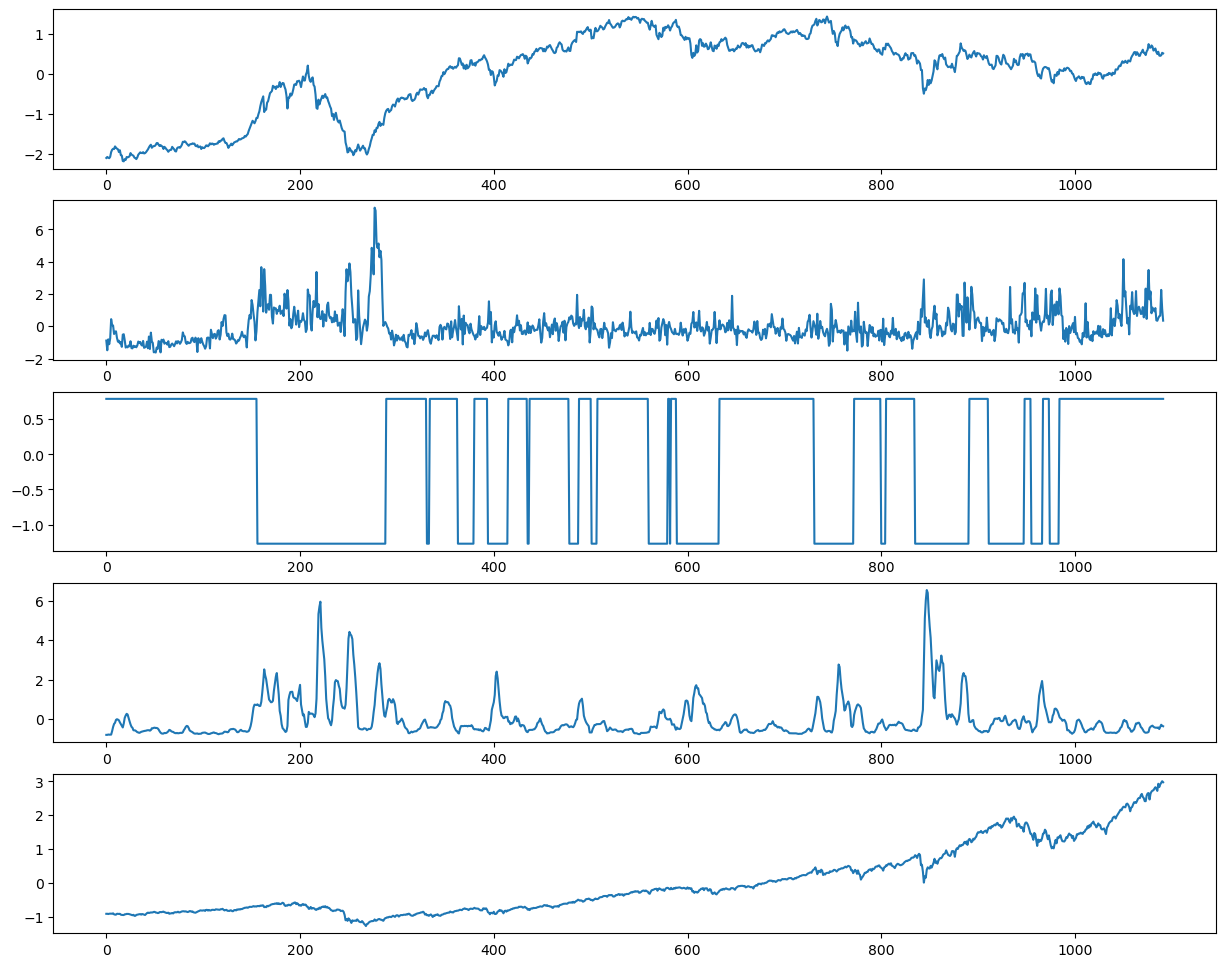

In [4]:
# EDA
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15,12))
axs[0].plot(price)
axs[1].plot(feat[:,0])
axs[2].plot(feat[:,1])
axs[3].plot(feat[:,2])
axs[4].plot(feat[:,3])
# axs[5].plot(feat[:,4])
# axs[6].plot(feat[:,5])
# axs[7].plot(feat[:,6])
# axs[8].plot(feat[:,7])

## Volume is not used in this Model

In [16]:
def LSTM_Model(data, feat):
    input1 = Input(shape=data)
    input2 = Input(shape=feat)

    input3 = input1[:,-104:]
    input4 = input2[:,-104:]
    
    input5 = Concatenate()([input3, input4[:,:,1:3]])

    length = 13
    
    input6 = Concatenate()([input3[:,-length:], input4[:,-length:,1:3]])
    
    
    aa = Masking(mask_value=-10000)(input5)
    aa = LSTM(units=150, activation='tanh', return_sequences=True, use_bias=True)(aa)
    aa = LSTM(units=100, activation='tanh', return_sequences=True)(aa)

    bb = Masking(mask_value=-10000)(input6)
    bb = LSTM(units=150, activation='tanh', return_sequences=True, use_bias=True)(bb)
    bb = LSTM(units=100, activation='tanh', return_sequences=True)(bb)

    
    long_concat = Concatenate()([aa, input4[:,:,3:]])
    short_concat = Concatenate()([bb, input4[:,-length:, 3:]])

    
    x = Masking(mask_value=-10000)(long_concat)
    x = LSTM(units=60, activation='tanh', return_sequences=False, use_bias=True, dropout=0.6)(x)

    y = Masking(mask_value=-10000)(short_concat)
    y = LSTM(units=60, activation='tanh', return_sequences=False, use_bias=True, dropout=0.3)(y)


    output_concat = Concatenate()([x,y])
    
    output = Dense(80, use_bias=True)(output_concat)
    output = Dense(53)(output)


    model = Model(inputs=[input1, input2], outputs=output)
    
    #beta_1, beta_2, clipnorm, weight_decay yet to be tested
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.001)
    
    # Must use MSE, not MAPE: Diff in calc loss func and hence BPN
    model.compile(optimizer=opt, loss='mse')

    return model


# Build the model
# Rerun if need to reset model
model = LSTM_Model((x.shape[1], x.shape[2],), (f.shape[1], f.shape[2],))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 600, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 600, 4)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_14 (GetItem)         │ (None, 104, 1)            │               0 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_15 (GetItem)         │ (None, 104, 4)            │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_16 (GetItem)         │ (None, 104, 2)            │               0 │ get_item_15[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_17 (GetItem)         │ (None, 13, 1)             │               0 │ get_item_14[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_18 (GetItem)         │ (None, 13, 2)             │               0 │ get_item_15[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_14 (Concatenate)  │ (None, 104, 3)            │               0 │ get_item_14[0][0],         │
│                               │                           │                 │ get_item_16[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_15 (Concatenate)  │ (None, 13, 3)             │               0 │ get_item_17[0][0],         │
│                               │                           │                 │ get_item_18[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_8 (NotEqual)        │ (None, 104, 3)            │               0 │ concatenate_14[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_9 (NotEqual)        │ (None, 13, 3)             │               0 │ concatenate_15[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking_8 (Masking)           │ (None, 104, 3)            │               0 │ concatenate_14[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any_12 (Any)                  │ (None, 104)               │               0 │ not_equal_8[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking_9 (Masking)           │ (None, 13, 3)             │               0 │ concatenate_15[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any_13 (Any)                  │ (None, 13)                │               0 │ not_equal_9[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_12 (LSTM)                │ (None, 104, 150)          │          92,400 │ masking_8[0][0],           │
│                               │                           │               

 Total params: 477,333 (1.82 MB)

 Trainable params: 477,333 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
def Model_train(x, f, y):

    pf = []
    ES = EarlyStopping(monitor='val_loss', patience=15, start_from_epoch=15, restore_best_weights=True, verbose=1)

    size = int(len(x) * 0.95)
    x_train, x_val = x[:size], x[size:]
    f_train, f_val = f[:size], f[size:]
    y_train, y_val = y[:size], y[size:]
    
    print(x_train.shape, x_val.shape)

    
    history = model.fit([x_train, f_train], y_train, epochs=50,
                        validation_data=([x_val, f_val], y_val), callbacks=[ES], batch_size=10)

    for epoch in range(len(history.history['loss'])):
        pf.append([epoch + 1, history.history['loss'][epoch], history.history['val_loss'][epoch]])

    return pd.DataFrame(pf)

pf = Model_train(x[:], f[:], y[:])
display(pf)

(88, 600, 1) (5, 600, 1)
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 635ms/step - loss: 0.6595 - val_loss: 0.0521
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - loss: 0.6504 - val_loss: 0.0496
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - loss: 0.6386 - val_loss: 0.0478
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - loss: 0.6950 - val_loss: 0.0461
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - loss: 0.6257 - val_loss: 0.0455
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - loss: 0.5390 - val_loss: 0.0466
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - loss: 0.4547 - val_loss: 0.0519
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - loss: 0.3753 - val_loss: 0.0611
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - loss: 0.3603 - val_loss: 0.0667
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - loss: 0.3276 - val_loss: 0.0700
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - loss: 0.2643 - val_loss: 0.0718
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/st

,0,1,2
0,1,0.742931,0.052074
1,2,0.715346,0.049606
2,3,0.680466,0.047795
3,4,0.629649,0.046064
4,5,0.577746,0.045483
5,6,0.515876,0.046626
6,7,0.452220,0.051866
7,8,0.388727,0.061131
8,9,0.335577,0.066662
9,10,0.309422,0.069977


(1, 1092, 1) (1, 1092, 4)
(1, 1091, 1) (1, 1091, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


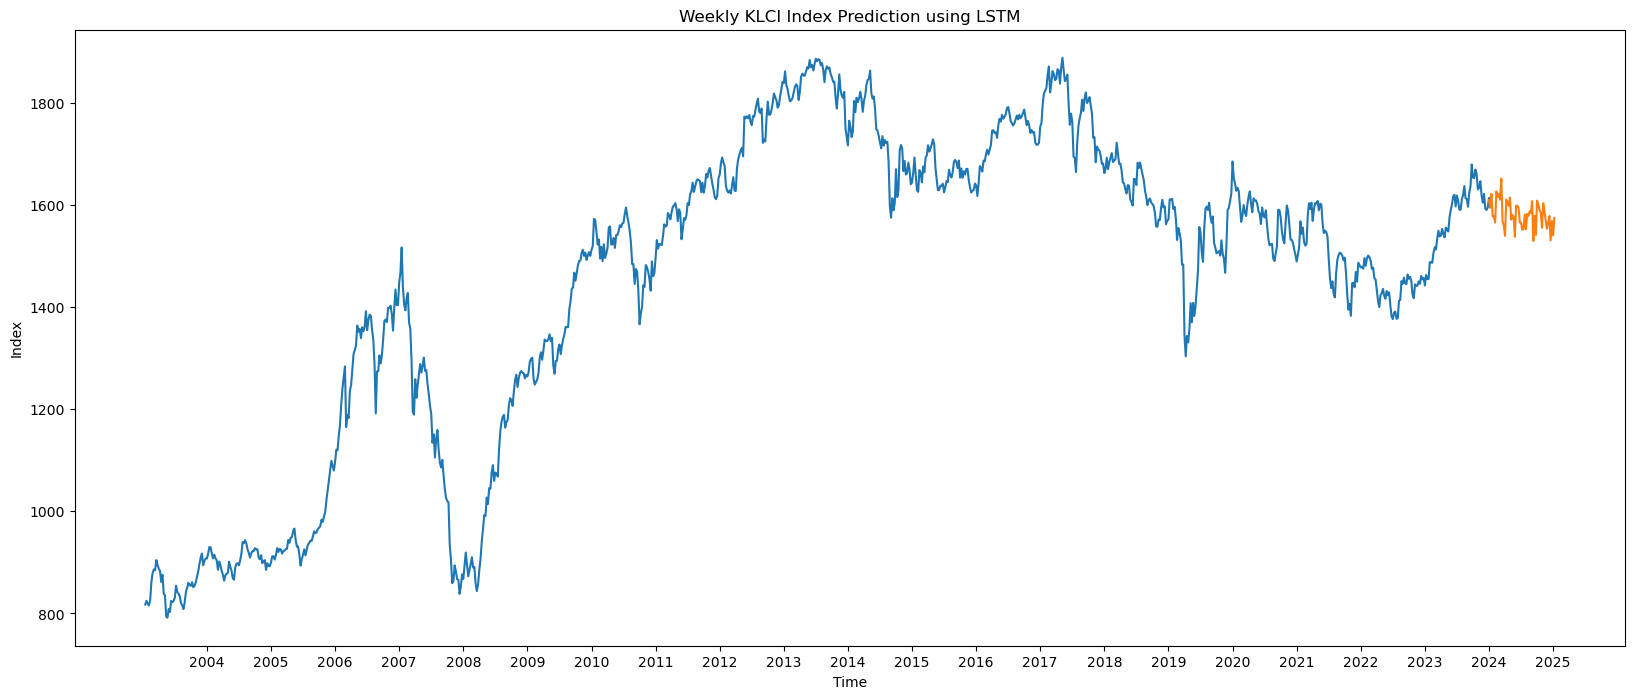

In [19]:
def Test(t, price, feat):
    
    p = pscaler.transform(price.reshape(-1, 1))
    f = fscaler.transform(feat.reshape(-1, 4))

    p = p.reshape(1,-1,1)
    f = f.reshape(1,-1,4)

    print(p.shape, f.shape)
    print(p[:,:t].shape, f[:,:t].shape)

    a = pad_sequences(p[:,:t], maxlen=600, padding='pre', value=-10000, dtype='float32')
    b = pad_sequences(f[:,:t], maxlen=600, padding='pre', value=-10000, dtype='float32')

    p = model.predict([a,b])
    # plt.subplots(figsize=(20,5))
    # plt.plot(a.reshape(-1,1))
    # plt.plot(range(a.shape[1],a.shape[1]+10), p.reshape(-1,1), color='red')
    # plt.show()
    # print(p)
    p = pscaler.inverse_transform(p.reshape(-1,1))

    re = p
    # To let data output horizontally
    plt.subplots(figsize=(20,8))
    plt.plot(price);
    p = np.insert(p, 0, [price[t]], axis=0)
    plt.plot(range(t-1,53+t), p);
    plt.title("Weekly KLCI Index Prediction using LSTM")
    plt.xlabel("Time")
    plt.ylabel('Index')

    x = np.arange(50, 1150, 52)
    start_year = 2004
    tick_labels = [str(start_year + i) for i in range(len(x))]
    plt.xticks(ticks=x, labels=tick_labels);

    return re

time = 1091
pred = Test(time, price_ori, np.array(feat_ori))

In [20]:
def Save_Model(model, name):
    model.save(f'{str(name)}.keras')
    return

def Load_Model(name):
    m = tf.keras.models.load_model(f'{str(name)}.keras')
    return m

# Save_Model(model, 'LSTM v4.1')

In [21]:
Save_Model(model, 'LSTM v54.2_KLCI')

In [22]:
concat_d = pd.concat([pd.DataFrame(price_ori), pd.DataFrame(pred)], axis=0, ignore_index=True)

extended_date_range = pd.date_range('2004-01-12', periods=len(concat_d), freq='W-Mon')
concat_d = concat_d.set_index(extended_date_range)   
display(concat_d)

concat_d.to_excel('KLCI Prediction.xlsx')

,0
2004-01-12,817.270020
2004-01-19,824.659973
2004-01-26,818.940002
2004-02-02,815.419983
2004-02-09,825.909973
...,...
2025-11-17,1578.000000
2025-11-24,1530.000000
2025-12-01,1568.000000
2025-12-08,1540.000000
